# Предобученный UNet для семантической сегментации

В этом ноутбуке мы реализуем обучение предобученной модели UNet для семантической сегментации на датасете CamVid. Используем PyTorch Lightning для обучения модели.


## Установка зависимостей

Устанавливаем библиотеку segmentation_models_pytorch для работы с предобученными моделями сегментации.


In [283]:
# !pip3 install -q segmentation-models-pytorch albumentations pytorch_lightning 


In [286]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
torch.set_float32_matmul_precision("high")
torch.backends.cudnn.benchmark = True 

## Импорты и настройка

Импортируем необходимые библиотеки для работы с предобученным UNet, PyTorch Lightning и обработки данных.


In [287]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import segmentation_models_pytorch as smp

class FocalLoss(nn.Module):
    """
    Multi-class Focal Loss for classification or segmentation.

    Supports:
      - logits: [B, C] (classification) or [B, C, H, W] (segmentation)
      - targets: [B] or [B, H, W] with class indices in [0..C-1]
    """

    def __init__(
        self,
        gamma: float = 2.0,
        alpha=None,                 # None | float | list/tuple | torch.Tensor of shape [C]
        ignore_index: int | None = None,
        reduction: str = "mean",    # "mean" | "sum" | "none"
        label_smoothing: float = 0.0,
    ):
        super().__init__()
        if reduction not in ("mean", "sum", "none"):
            raise ValueError("reduction must be one of: 'mean', 'sum', 'none'")
        self.gamma = float(gamma)
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.label_smoothing = float(label_smoothing)

        if alpha is None:
            self.alpha = None
        else:
            if isinstance(alpha, (float, int)):
                self.alpha = torch.tensor([float(alpha)])
            else:
                self.alpha = torch.tensor(alpha, dtype=torch.float)

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        logits:  [B, C] or [B, C, H, W]
        targets: [B] or [B, H, W] (class indices)
        """
        if logits.dim() < 2:
            raise ValueError("logits must have shape [B,C,...]")

        num_classes = logits.size(1)

        # Move alpha to correct device/dtype
        alpha = None
        if self.alpha is not None:
            if self.alpha.numel() == 1:
                alpha = self.alpha.to(device=logits.device, dtype=logits.dtype)
            else:
                if self.alpha.numel() != num_classes:
                    raise ValueError(f"alpha must have shape [C]={num_classes}, got {self.alpha.numel()}")
                alpha = self.alpha.to(device=logits.device, dtype=logits.dtype)

        # Flatten to [N, C] and [N]
        if logits.dim() == 2:
            logits_flat = logits
            targets_flat = targets
        else:
            # [B,C,H,W] -> [B,H,W,C] -> [N,C]
            logits_flat = logits.permute(0, *range(2, logits.dim()), 1).contiguous().view(-1, num_classes)
            targets_flat = targets.view(-1)

        targets_flat = targets_flat.long()

        # Ignore index mask
        if self.ignore_index is not None:
            valid = targets_flat != self.ignore_index
            logits_flat = logits_flat[valid]
            targets_flat = targets_flat[valid]

        if targets_flat.numel() == 0:
            # all ignored; return 0 that keeps graph
            return logits.sum() * 0.0

        # CE per element (no reduction)
        ce = F.cross_entropy(
            logits_flat,
            targets_flat,
            reduction="none",
            label_smoothing=self.label_smoothing,
        )

        # pt = exp(-CE) = prob of true class
        pt = torch.exp(-ce)

        # Focal factor
        focal = (1.0 - pt).pow(self.gamma)

        # Alpha weighting
        if alpha is None:
            loss = focal * ce
        else:
            if alpha.numel() == 1:
                a_t = alpha.expand_as(ce)
            else:
                a_t = alpha.gather(0, targets_flat)
            loss = a_t * focal * ce

        # Reduction
        if self.reduction == "mean":
            return loss.mean()
        if self.reduction == "sum":
            return loss.sum()
        return loss

torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)

img_size_const = (512, 512)
learning_rate_const = learning_rate=1e-4
encoder_name = "resnet50"
# encoder_name = "resnet50"

Seed set to 42


## Аугментации данных

Определяем аугментации для обучения и валидации с использованием библиотеки albumentations.


In [288]:
def get_train_augmentation(img_size = img_size_const):
    return A.Compose([
        A.Resize(img_size[0], img_size[1],interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=7, p=0.5, border_mode=cv2.BORDER_CONSTANT, interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST),
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # A.ElasticTransform(alpha=6, sigma=10, alpha_affine=4, p=0.1),
        # A.CoarseDropout(max_holes=6, max_height=img_size[0]//12,min_holes=0, max_width=img_size[1],fill_value=0,p=0.2),
    ])

def get_val_augmentation(img_size = img_size_const):
    return A.Compose([
        A.Resize(img_size[0], img_size[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

## Датасет для сегментации

Используем CamVid для семантической сегментации. Датасет содержит 12 классов дорожных сцен.


In [289]:
class CamVidDataset(Dataset):
    def __init__(self, data_dir, split='train', img_size = img_size_const, transform=None):
        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform
        self.camvid_raw_to_target_map = {
            0: 0,
            22: 1,
            34: 2,
            38: 3,
            41: 4,
            45: 5,
            57: 6,
            60: 7,
            83: 8,
            90: 9,
            97: 10,
            113: 11,
            116: 11,
            121: 11,
            128: 11,
            132: 11,
            170: 11,
            185: 11,
        }

        self.mapping_array = np.full(256, 11, dtype=np.int64)
        for k, v in self.camvid_raw_to_target_map.items():
            if k < 256:
                self.mapping_array[k] = v

        txt_file = os.path.join(data_dir, split + '.txt')
        self.samples = []

        with open(txt_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split()
                    if len(parts) >= 2:
                        img_path_abs = parts[0]
                        mask_path_abs = parts[1]
                        img_filename = os.path.basename(img_path_abs)
                        mask_filename = os.path.basename(mask_path_abs)
                        img_path = os.path.join(data_dir, split, img_filename)
                        mask_path = os.path.join(data_dir, split + 'annot', mask_filename)
                        if os.path.exists(img_path) and os.path.exists(mask_path):
                            self.samples.append((img_path, mask_path))
        print("Loaded {} samples from {} split".format(len(self.samples), split))

    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'))

        mask = self.mapping_array[mask].astype(np.int64)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

            if isinstance(image, np.ndarray):
                image = torch.from_numpy(image).permute(2, 0, 1).float()
            if isinstance(mask, np.ndarray):
                mask = torch.from_numpy(mask).long()
        else:

            image = Image.fromarray(image).resize(self.img_size, Image.BILINEAR)
            image = np.array(image).astype(np.float32) / 255.0
            mask = Image.fromarray(mask).resize(self.img_size, Image.NEAREST)
            mask = np.array(mask).astype(np.int64)

            image = torch.from_numpy(image).permute(2, 0, 1)
            mask = torch.from_numpy(mask)

        return image, mask

## Архитектура предобученного UNet

Используем предобученную модель UNet из библиотеки segmentation_models_pytorch. UNet с предобученным энкодером ResNet34 обеспечивает хорошее качество сегментации.


In [290]:

encoder_weights = "imagenet"

model = smp.Unet(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    in_channels=3,
    classes=12,
)

print(f"Model: UNet with {encoder_name} encoder")
print(f"Encoder weights: {encoder_weights}")
print(f"Number of classes: 12")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")


Model: UNet with resnet50 encoder
Encoder weights: imagenet
Number of classes: 12
Number of parameters: 32,522,700


## Lightning модуль для обучения

Создаём PyTorch Lightning модуль для обучения модели UNet.


In [321]:
class UNetModule(pl.LightningModule):
    def __init__(self, model, learning_rate=learning_rate_const):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])

        self.model = model
        self.learning_rate = learning_rate
        self.n_classes = 12
        self.dice = smp.losses.DiceLoss(mode="multiclass", from_logits=True, ignore_index=11)
        self.focal = FocalLoss(gamma=2.0, alpha=None, ignore_index=11)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch

        logits = self.forward(images)

        # loss = F.cross_entropy(logits, masks)
        # loss = focal(logits, masks)
        loss = 0.5 *  F.cross_entropy(logits, masks) + 0.5 * self.dice(logits, masks)

        preds = torch.argmax(logits, dim=1)
        iou = self.compute_iou(preds, masks)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_iou', iou, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        num_classe = 12
        logits = self.forward(images)

        # loss = F.cross_entropy(logits, masks)
        # loss = focal(logits, masks)
        loss = 0.5 *  F.cross_entropy(logits, masks) + 0.5 * self.dice(logits, masks)

        preds = torch.argmax(logits, dim=1)
        iou = self.compute_iou(preds, masks)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_iou', iou, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        logits = self.forward(images)

        
        # loss = F.cross_entropy(logits, masks)
        # loss = focal(logits, masks)
        loss = 0.5 *  F.cross_entropy(logits, masks) + 0.5 * self.dice(logits, masks)

        preds = torch.argmax(logits, dim=1)
        iou = self.compute_iou(preds, masks)

        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_iou', iou, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def compute_iou(self, preds, targets):
        ious = []
        for cls in range(self.n_classes):
            pred_cls = (preds == cls)
            target_cls = (targets == cls)
            intersection = (pred_cls & target_cls).float().sum((1, 2))
            union = (pred_cls | target_cls).float().sum((1, 2))
            iou = (intersection + 1e-6) / (union + 1e-6)
            ious.append(iou.mean())
        return torch.stack(ious).mean()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=0.0001)

        if hasattr(self.trainer, 'estimated_stepping_batches') and self.trainer.estimated_stepping_batches:
            total_steps = self.trainer.estimated_stepping_batches
        else:
            total_steps = self.trainer.max_epochs * 1000

        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.learning_rate * 10,
            total_steps=total_steps,
            pct_start=0.3,
            anneal_strategy='cos'
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }
    def freeze_encoder(self):
        for p in self.model.encoder.parameters():
            p.requires_grad = False
        
    def unfreeze_encoder(self):
        for p in self.model.encoder.parameters():
            p.requires_grad = True

## Загрузка данных

Создаём даталоадеры для обучения и валидации.


In [322]:
data_dir = './data/'

train_transform = get_train_augmentation(img_size = img_size_const)
val_transform = get_val_augmentation(img_size = img_size_const)

train_dataset = CamVidDataset(
    data_dir=data_dir,
    split ="train",
    img_size = img_size_const,
    transform=train_transform
)

val_dataset = CamVidDataset(
    data_dir=data_dir,
    split='val',
    img_size = img_size_const,
    transform=val_transform
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

batch_size = 16
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)


Loaded 369 samples from train split
Loaded 100 samples from val split
Train samples: 369
Val samples: 100


C:\Users\arsen\AppData\Local\Temp\ipykernel_5176\242955591.py:7: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=H, min_width=W,
C:\Users\arsen\AppData\Local\Temp\ipykernel_5176\242955591.py:12: UserWarning: Argument(s) 'value, mask_value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
C:\Users\arsen\AppData\Local\Temp\ipykernel_5176\242955591.py:28: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=H, min_width=W,


## Визуализация данных

Проверяем загрузку данных и визуализируем примеры изображений и масок.


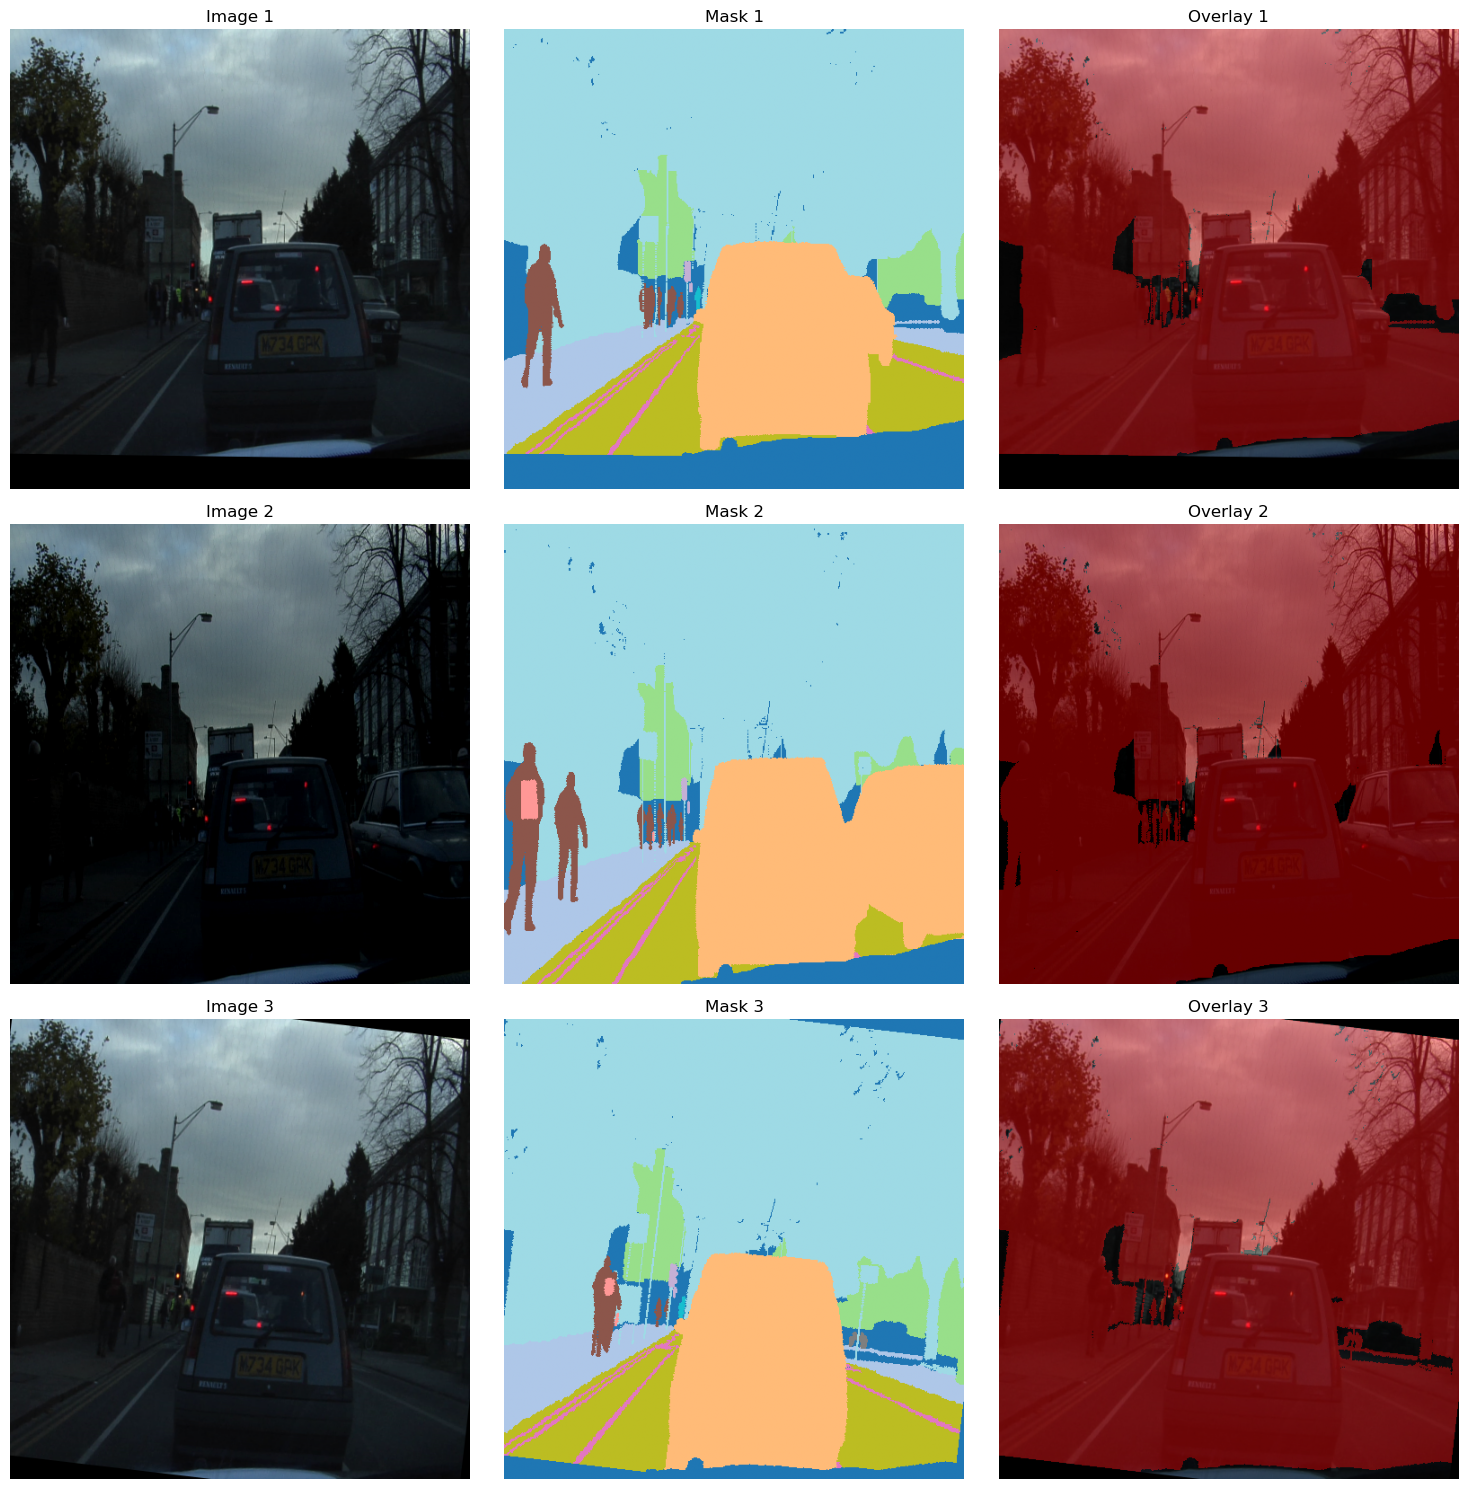

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([512, 512])
Mask unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])


In [298]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    image, mask = train_dataset[i]

    img_np = image.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)

    mask_np = mask.numpy()

    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f'Image {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=11)
    axes[i, 1].set_title(f'Mask {i+1}')
    axes[i, 1].axis('off')

    overlay = img_np.copy()
    mask_colored = np.zeros_like(img_np)
    mask_colored[mask_np > 0] = [1, 0, 0]
    overlay = overlay * 0.6 + mask_colored * 0.4

    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f'Overlay {i+1}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Mask unique values: {torch.unique(mask)}")


## Инициализация модели

Создаём модель UNet и Lightning модуль для обучения.


In [299]:
unet_module = UNetModule(
    model=model,
    learning_rate=learning_rate_const
)

sample_input = torch.randn(1, 3, 256, 256)
with torch.no_grad():
    sample_output = unet_module(sample_input)

print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(f"Model parameters: {sum(p.numel() for p in unet_module.parameters()):,}")


Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 12, 256, 256])
Model parameters: 32,522,700


## Тензорборд для отслеживания между обучениями

In [318]:
import pytorch_lightning as pl
import torch
import torchmetrics

class UnetModule(pl.LightningModule):
    def __init__(self, model, num_classes: int, ignore_index: int = 11, class_names=None, lr=learning_rate_const):
        super().__init__()
        self.model = model
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.class_names = class_names or [f"class_{i}" for i in range(num_classes)]
        self.lr = lr

        self.val_iou_mean = torchmetrics.JaccardIndex(
            task="multiclass",
            num_classes=num_classes,
            ignore_index=ignore_index,
            average="macro",
        )

        self.val_iou_pc = torchmetrics.JaccardIndex(
            task="multiclass",
            num_classes=num_classes,
            ignore_index=ignore_index,
            average=None,  # <- ключевой момент
        )

    def forward(self, x):
        return self.model(x)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        if y.ndim == 4:
            y = y.squeeze(1)

        logits = self(x)              
        preds = logits.argmax(dim=1)  

        self.val_iou_mean.update(preds, y)
        self.val_iou_pc.update(preds, y)

    def on_validation_epoch_end(self):
        iou_mean = self.val_iou_mean.compute()
        self.log("val_iou", iou_mean, prog_bar=True, on_epoch=True)

        iou_pc = self.val_iou_pc.compute()  
        for i in range(self.num_classes):
            if i == self.ignore_index:
                continue
            name = self.class_names[i] if i < len(self.class_names) else f"class_{i}"
            self.log(f"val_iou/{i:02d}_{name}", iou_pc[i], on_epoch=True, prog_bar=False)

        self.val_iou_mean.reset()
        self.val_iou_pc.reset()



    # def configure_optimizers(self):
    #     opt = torch.optim.AdamW(self.parameters(), lr=self.lr)
    #     return opt
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)


In [301]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 28920), started 10:14:28 ago. (Use '!kill 28920' to kill it.)

## Обучение модели

Настраиваем callbacks и запускаем обучение с использованием PyTorch Lightning.


In [302]:


checkpoint_callback = ModelCheckpoint(
    monitor='val_iou',
    mode='max',
    save_top_k=1,
    filename='unet-{epoch:02d}-{val_iou:.4f}',
    save_last=True
)

early_stop_callback = EarlyStopping(
    monitor='val_iou',
    mode='max',
    patience=60,
    verbose=True
)

logger = TensorBoardLogger('lightning_logs', name='unet_segmentation')

trainer = pl.Trainer(
    max_epochs=200,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    precision='16-mixed',
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=logger,
    log_every_n_steps=10,
    val_check_interval=0.5
)

trainer.fit(unet_module, train_loader, val_loader)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type      ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ Unet      │ 32.5 M │ train │     0 │
│ 1 │ dice  │ DiceLoss  │      0 │ train │     0 │
│ 2 │ focal │ FocalLoss │      0 │ train │     0 │
└───┴───────┴───────────┴────────┴───────┴───────┘

Trainable params: 32.5 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 32.5 M                                                                                               
Total estimated model params size (MB): 130                                                                        
Modules in train mode: 225                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_iou improved. New best score: 0.055
Metric val_iou improved by 0.045 >= min_delta = 0.0. New best score: 0.099
Metric val_iou improved by 0.032 >= min_delta = 0.0. New best score: 0.131
Metric val_iou improved by 0.043 >= min_delta = 0.0. New best score: 0.174
Metric val_iou improved by 0.045 >= min_delta = 0.0. New best score: 0.220
Metric val_iou improved by 0.025 >= min_delta = 0.0. New best score: 0.244
Metric val_iou improved by 0.016 >= min_delta = 0.0. New best score: 0.261
Metric val_iou improved by 0.010 >= min_delta = 0.0. New best score: 0.271
Metric val_iou improved by 0.010 >= min_delta = 0.0. New best score: 0.282
Metric val_iou improved by 0.009 >= min_delta = 0.0. New best score: 0.291
Metric val_iou improved by 0.011 >= min_delta = 0.0. New best score: 0.302
Metric val_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.303
Metric val_iou improved by 0.015 >= min_delta = 0.0. New best score: 0.318
Metric val_iou improved by 0.007 >= min_delta = 0.0. 

## Оценка на тестовом датасете

Оцениваем качество модели на тестовом датасете.


In [336]:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")


Best model path: lightning_logs\unet_segmentation\version_15\checkpoints\unet-epoch=26-val_iou=0.7035.ckpt


## Дообучение

In [332]:
best_ckpt = checkpoint_callback.best_model_path

ckpt = torch.load(best_ckpt, map_location="cpu")          
unet_module = UNetModule(model=model, learning_rate=1e-5)
unet_module.load_state_dict(ckpt["state_dict"], strict=True)




<All keys matched successfully>

In [333]:
unet_module.freeze_encoder()
trainer_a = pl.Trainer(max_epochs=7, precision="16-mixed", accelerator="gpu", devices=1, num_sanity_val_steps=0)
trainer_a.fit(unet_module, train_loader, val_loader)



Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type      ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ Unet      │ 32.5 M │ eval  │     0 │
│ 1 │ dice  │ DiceLoss  │      0 │ train │     0 │
│ 2 │ focal │ FocalLoss │      0 │ train │     0 │
└───┴───────┴───────────┴────────┴───────┴───────┘

Trainable params: 9.0 M                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 32.5 M                                                                                               
Total estimated model params size (MB): 130                                                                        
Modules in train mode: 2                                                                                           
Modules in eval mode: 223                                                                                          
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=7` reached.


In [334]:
unet_module.unfreeze_encoder()
trainer_b = pl.Trainer(max_epochs=30, precision="16-mixed", accelerator="gpu", devices=1,
                       callbacks=[checkpoint_callback, early_stop_callback], logger=logger,
                       num_sanity_val_steps=0)
trainer_b.fit(unet_module, train_loader, val_loader)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type      ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ Unet      │ 32.5 M │ eval  │     0 │
│ 1 │ dice  │ DiceLoss  │      0 │ train │     0 │
│ 2 │ focal │ FocalLoss │      0 │ train │     0 │
└───┴───────┴───────────┴────────┴───────┴───────┘

Trainable params: 32.5 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 32.5 M                                                                                               
Total estimated model params size (MB): 130                                                                        
Modules in train mode: 2                                                                                           
Modules in eval mode: 223                                                                                          
Total FLOPs: 0

Output()

Metric val_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.701
Metric val_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.703
`Trainer.fit` stopped: `max_epochs=30` reached.


## Оценка после дообучения

In [337]:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")


Best model path: lightning_logs\unet_segmentation\version_15\checkpoints\unet-epoch=26-val_iou=0.7035.ckpt


## Визуализация результатов

Визуализируем предсказания модели на нескольких примерах из валидационного датасета.


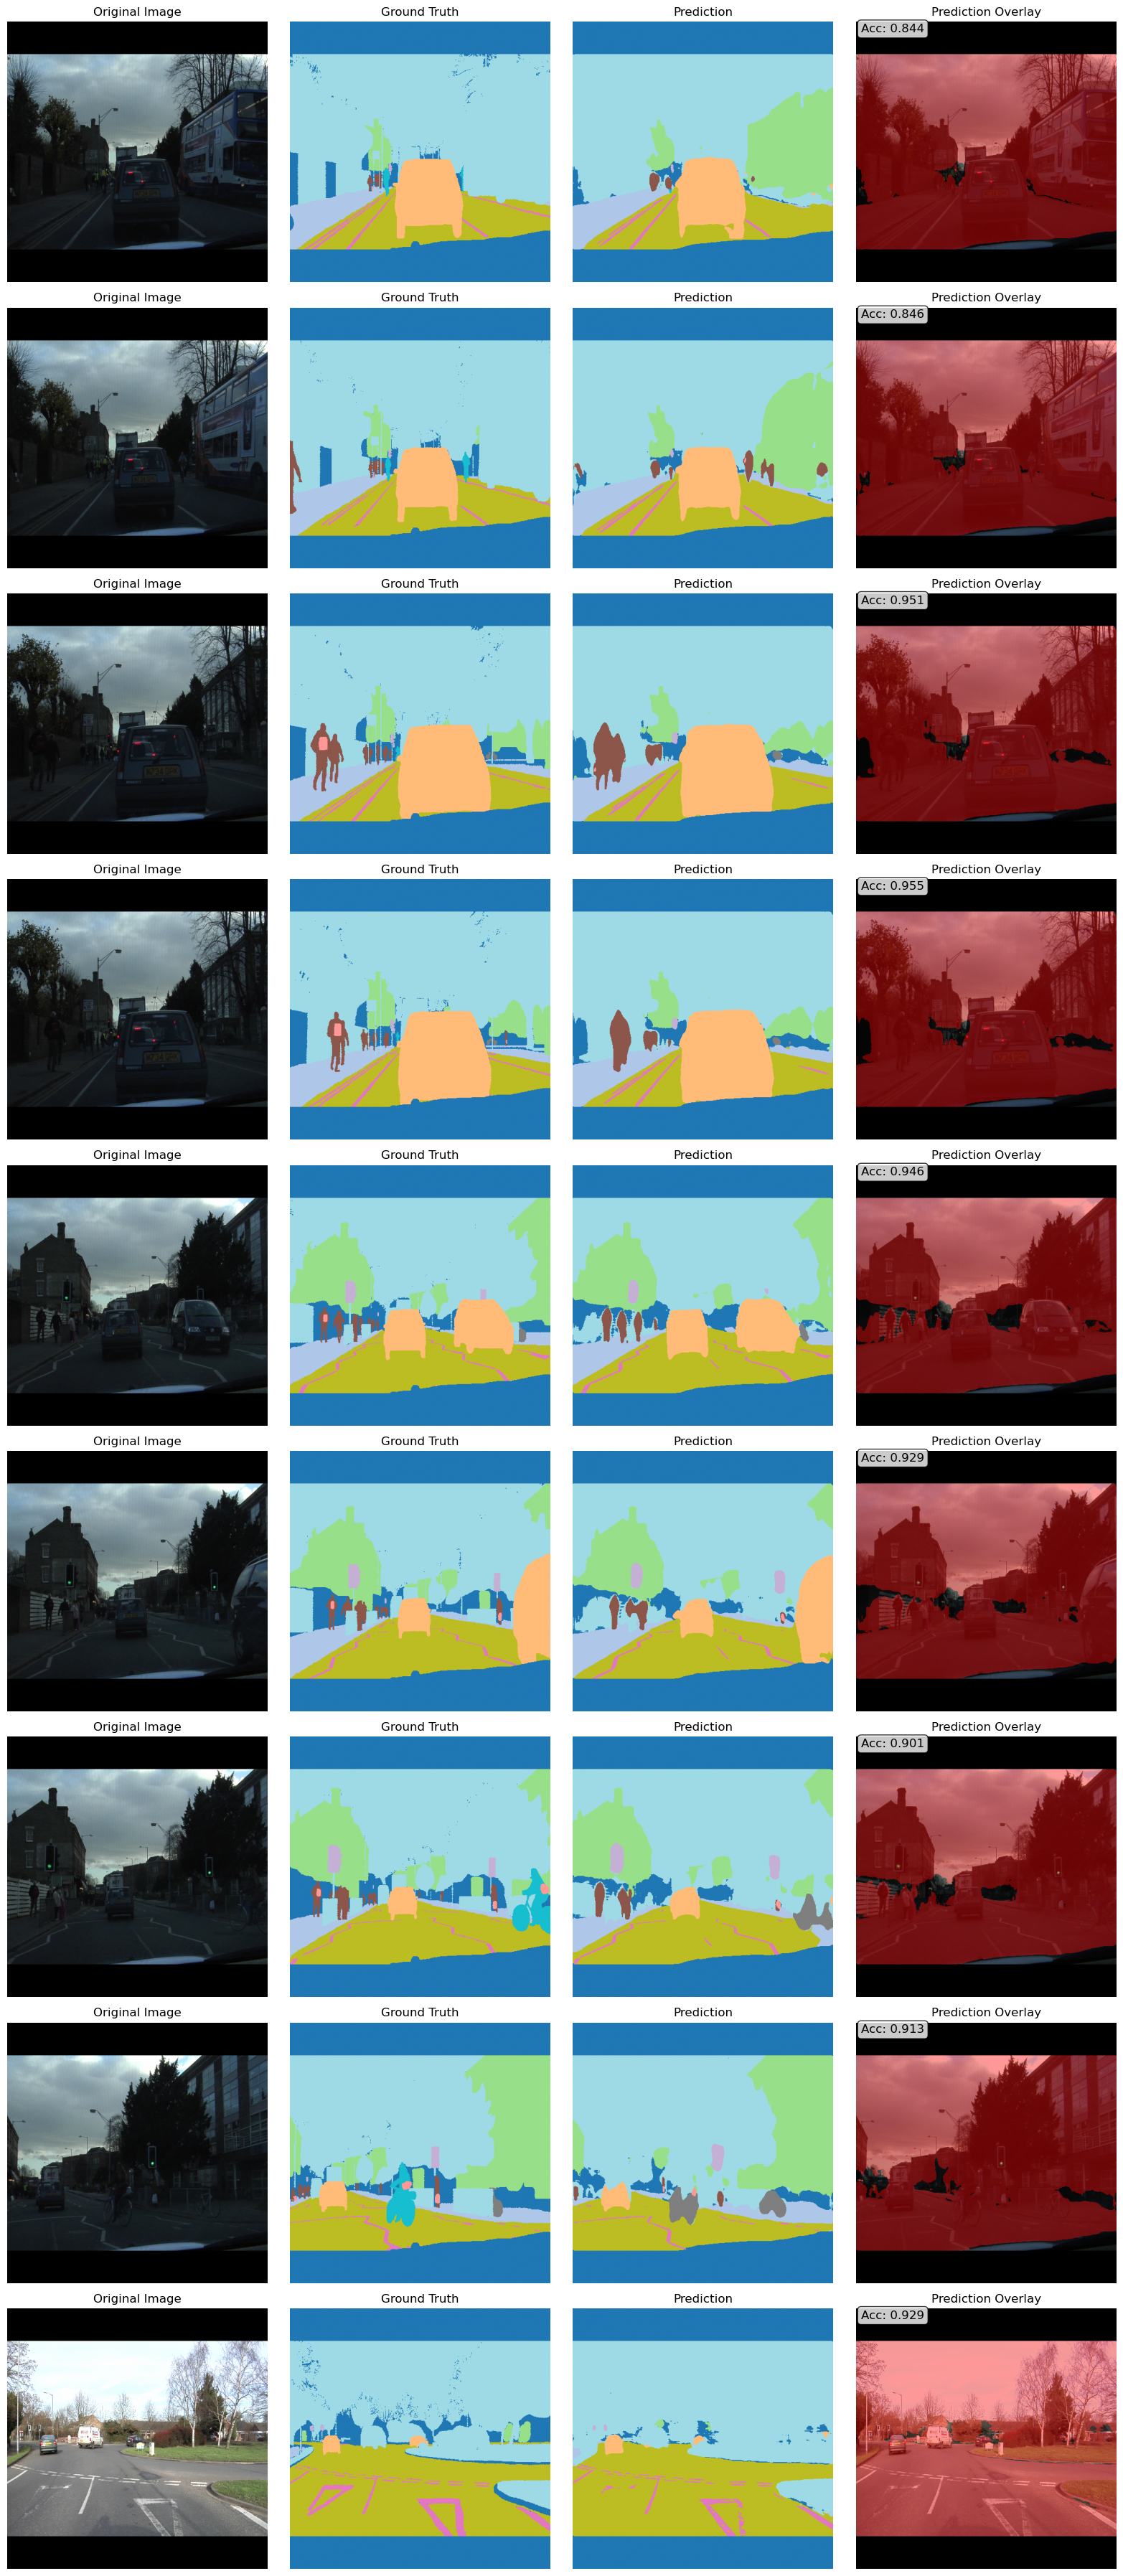

In [335]:
unet_module.eval()
device = next(unet_module.parameters()).device

num_samples = 9
fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

with torch.no_grad():
    for idx in range(num_samples):
        image, mask = val_dataset[idx]
        image_batch = image.unsqueeze(0).to(device)

        logits = unet_module(image_batch)
        pred = torch.argmax(logits, dim=1).cpu().squeeze()

        img_np = image.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)

        mask_np = mask.numpy()
        pred_np = pred.numpy()

        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=11)
        axes[idx, 1].set_title('Ground Truth')
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(pred_np, cmap='tab20', vmin=0, vmax=11)
        axes[idx, 2].set_title('Prediction')
        axes[idx, 2].axis('off')

        overlay = img_np.copy()
        pred_colored = np.zeros_like(img_np)
        pred_colored[pred_np > 0] = [1, 0, 0]
        overlay = overlay * 0.6 + pred_colored * 0.4

        axes[idx, 3].imshow(overlay)
        axes[idx, 3].set_title('Prediction Overlay')
        axes[idx, 3].axis('off')

        correct = (pred_np == mask_np).sum()
        total = mask_np.size
        pixel_acc = correct / total
        axes[idx, 3].text(10, 20, f'Acc: {pixel_acc:.3f}',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                          fontsize=12, color='black')

plt.tight_layout()
plt.show()


## Метрики на валидационном датасете

Вычисляем детальные метрики на валидационном датасете.


In [338]:
def compute_metrics(preds, targets, n_classes=12):
    ious = []
    for cls in range(n_classes):
        pred_cls = (preds == cls)
        target_cls = (targets == cls)
        intersection = (pred_cls & target_cls).float().sum((1, 2))
        union = (pred_cls | target_cls).float().sum((1, 2))
        iou = (intersection + 1e-6) / (union + 1e-6)
        ious.append(iou.mean().item())

    mean_iou = np.mean(ious)

    correct = (preds == targets).float().sum((1, 2))
    total = targets.numel() // targets.shape[0]
    pixel_acc = correct.sum().item() / (targets.shape[0] * total)

    return {
        'mean_iou': mean_iou,
        'iou_per_class': ious,
        'pixel_acc': pixel_acc
    }

unet_module.eval()
all_preds = []
all_targets = []

val_loader_eval = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

with torch.no_grad():
    for images, masks in tqdm(val_loader_eval, desc="Evaluating"):
        images = images.to(device)
        logits = unet_module(images)
        preds = torch.argmax(logits, dim=1).cpu()

        all_preds.append(preds)
        all_targets.append(masks)

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

metrics = compute_metrics(all_preds, all_targets, n_classes=12)

camvid_classes = ['Sky', 'Building', 'Column-Pole', 'Road', 'Sidewalk', 'Tree', 'Sign-Symbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Void']

print("="*60)
print("Validation Metrics:")
print("="*60)
print(f"Mean IoU: {metrics['mean_iou']:.4f}")
print(f"Pixel Accuracy: {metrics['pixel_acc']:.4f}")
print("\nIoU per class:")
for cls_name, iou in zip(camvid_classes, metrics['iou_per_class']):
    print(f"  {cls_name}: {iou:.4f}")
print("="*60)


Evaluating: 100%|██████████| 7/7 [01:14<00:00, 10.66s/it]


Validation Metrics:
Mean IoU: 0.7003
Pixel Accuracy: 0.9455

IoU per class:
  Sky: 0.9420
  Building: 0.7374
  Column-Pole: 0.7373
  Road: 0.8124
  Sidewalk: 0.4648
  Tree: 0.6448
  Sign-Symbol: 0.4403
  Fence: 0.6020
  Car: 0.5413
  Pedestrian: 0.9408
  Bicyclist: 0.6734
  Void: 0.8674


## История попыток
## resnet34 + 512x512 + cross_entropy + 5e-4
Best model path: lightning_logs/unet_segmentation/version_6/checkpoints/unet-epoch=22-val_iou=0.5516.ckpt
## resnet50 + focalloss - elastic - crossfdrop + 512x512 + 5e-4
Best model path: lightning_logs\unet_segmentation\version_3\checkpoints\unet-epoch=04-val_iou=0.4489.ckpt
## resnet50 + cross_entropy  - elastic - crossfdrop + 512x512 + 5e-4
Best model path: lightning_logs\unet_segmentation\version_6\checkpoints\unet-epoch=49-val_iou=0.5402.ckpt
## efficientnet-b3 + cross_entropy  - elastic - crossfdrop + 512x512 + 5e-4
Best model path: lightning_logs\unet_segmentation\version_7\checkpoints\unet-epoch=05-val_iou=0.4458.ckpt
## resnet50  + cross_entropy  - elastic - crossfdrop + 512x384 + 5e-4
Best model path: lightning_logs\unet_segmentation\version_8\checkpoints\unet-epoch=49-val_iou=0.5390.ckpt
## resnet50  + cross_entropy  + elastic + crossfdrop + 512x384 + 5e-4
Best model path: lightning_logs\unet_segmentation\version_9\checkpoints\unet-epoch=43-val_iou=0.5435.ckpt
## resnet50  + cross_entropy  + elastic + crossfdrop + 512x384 + 5e-4 + 200ep
Best model path: lightning_logs\unet_segmentation\version_10\checkpoints\unet-epoch=21-val_iou=0.5267.ckpt
## resnet50  + focal_loss  + elastic + crossfdrop + 512x384 + 5e-4 + 200ep
Best model path: lightning_logs\unet_segmentation\version_12\checkpoints\unet-epoch=28-val_iou=0.4528.ckpt
## resnet50  + focal_loss  + elastic + crossfdrop + 512x512 + 5e-4 + 200ep
Best model path: lightning_logs\unet_segmentation\version_12\checkpoints\unet-epoch=28-val_iou=0.4528.ckpt
## resnet50  + focal_loss  + elastic + crossfdrop + 512x512 + 1e-3 + 200ep
Best model path: lightning_logs\unet_segmentation\version_14\checkpoints\unet-epoch=09-val_iou=0.4060.ckpt
## resnet50  + cross_entropy + dice  - elastic - crossfdrop + 512x512 + 1e-4 + 200ep
Best model path: lightning_logs\unet_segmentation\version_15\checkpoints\unet-epoch=36-val_iou=0.6254.ckpt
## resnet50  + cross_entropy + dice  - elastic - crossfdrop + 512x512 + 1e-4 + 200ep + дообучение + cross_entropy + dice + 7ep freeze + 30ep unfreeze + lr 1e-5
Best model path: lightning_logs\unet_segmentation\version_15\checkpoints\unet-epoch=26-val_iou=0.7035.ckpt

## Итог
## Позитивные влияния
Основное изменение дало изменение loss на составной cross_entropy + dice, модель более аккуратно оценивала результаты не придавая слишком много значения большим классам.
Также улучшить скор помог подбро learnin_rate под оптимальный, чтобы модель не уходила в краевые случаи и не перешагивала возможные пути улучшения.
Финального резултьтата помогло добавление дообучение, при том обучения с фризом энкодера, без него модель начинала перевзвешивать веса и "тупела", но без дополнительных итераций второй волны дообучения с размороженным энкодером не получилось бы добиться такой хорошей оценки.
Правильно подобранное разрешение помогло лучше определять мелкие детали
## Негативные влияния
Слишком агрессивная агументация только ухудшила обучение, сильно изменяя картинку модель переставала четко определять границы и размазывала объекты.
Дообучение без фриза не работает, так как модель начинает разучиваться и перезаписывать уже рабочие веса
Агрессивный lr все время уводил модель не туда, тогда я еще не записывал каждый шаг, но она улетала вплодь до 0.398

